## Try to maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv
import iminuit_minimizer

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=10
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 10 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.6215E-09, n_s = 9.7257E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_sim.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)

In [9]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 49.59859365028559


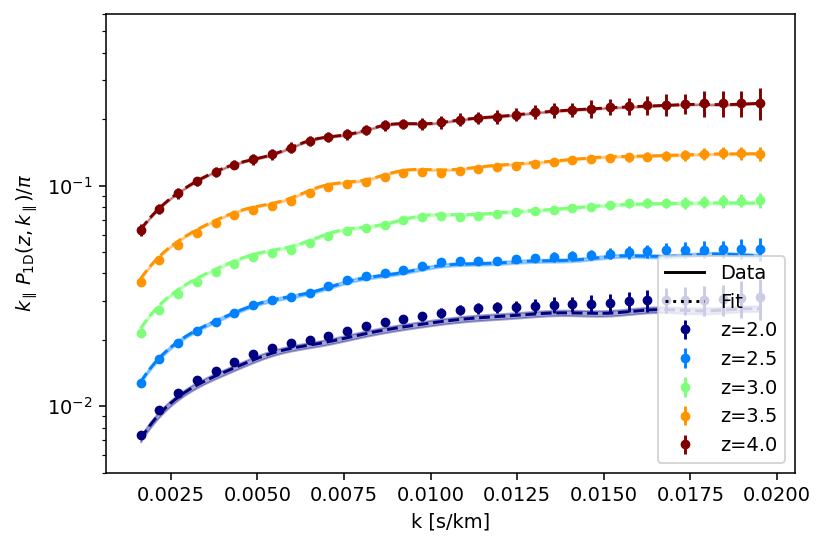

In [10]:
like.plot_p1d(plot_every_iz=2)

### Setup our own minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

best-fit values = [0.5 0.5 0.5 0.5 0.5]


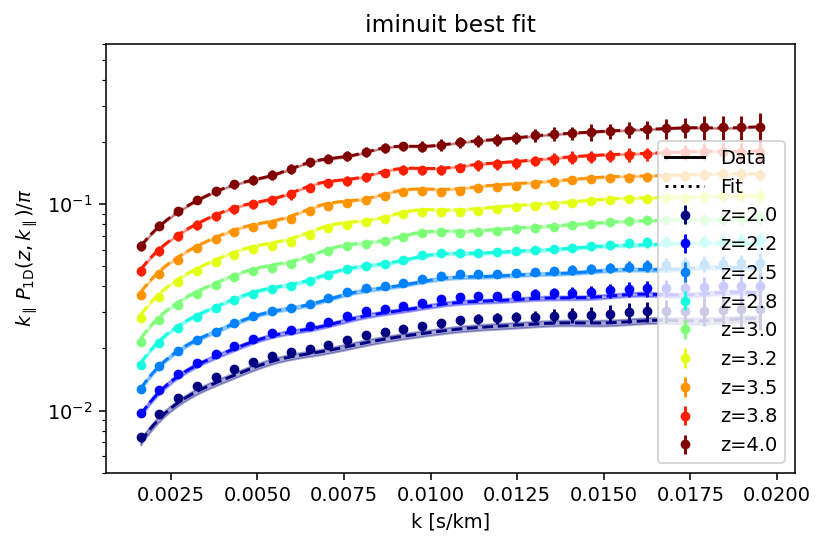

In [12]:
minimizer.plot_best_fit()

In [13]:
minimizer.minimize()

will run migrad


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = -14.75                  |     Ncalls=232 (232 total)     |
| EDM = 3.55e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix


best-fit values = [0.36023275 0.42032514 0.53730163 0.27083296 0.29500377]


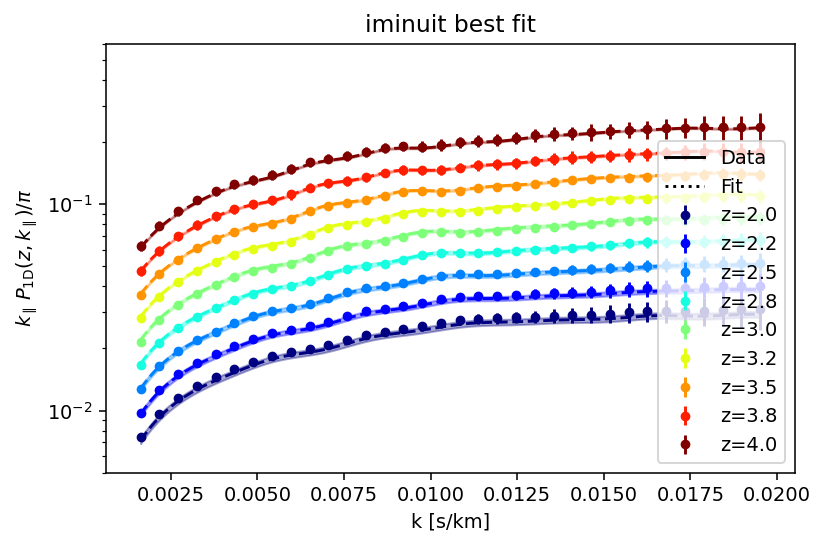

In [14]:
minimizer.plot_best_fit()

### Plot Gaussian contours after minimization

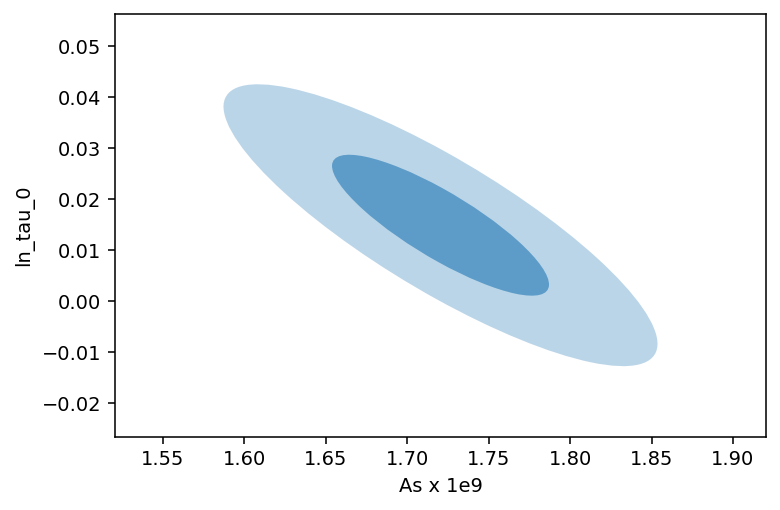

In [15]:
minimizer.plot_ellipses('As','ln_tau_0',cube_values=False) 

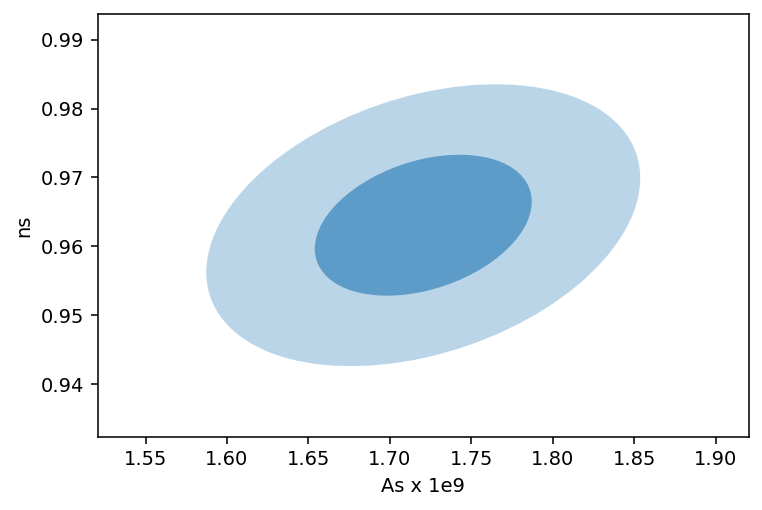

In [16]:
minimizer.plot_ellipses('As','ns',cube_values=False) 

In [17]:
if False:
    # compare with function from iminuit
    minimizer.plot_ellipses('As','ns',cube_values=True) 
    # this will take a while, it computes several minimizations
    minimizer.minimizer.draw_mncontour('x0','x1',numpoints=20)

# Run iminuit minimiser directly (without using our object)

In [18]:
from iminuit import Minuit

In [19]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [20]:
# run optimiser
m.migrad()

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = -14.75                  |     Ncalls=232 (232 total)     |
| EDM = 3.55e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.360   |   0.034   |            |            |         |         |       |
| 1 | x1   |   0.42    |   0.07    |            |            |         |         |       |
| 2 | x2   |   0.537   |   0.035   |            |            |         |         |       |
| 3 | x3   |   0.27    |   0.11    |            |            |         |         |       |
| 4 | x4   |    0.3    |    0.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [21]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7fe5f98be460>
  x0: 0.3602327507900864
  x1: 0.4203251357720133
  x2: 0.5373016254096191
  x3: 0.270832958204814
  x4: 0.2950037715441108


------------------------------------------------------------------
| FCN = -14.75                  |     Ncalls=232 (232 total)     |
| EDM = 3.55e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [22]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 8.382529059558165
As = 1.7204655015801728e-09
ns = 0.963048770365802
ln_tau_0 = 0.014920650163847637
ln_sigT_kms_0 = -0.229167041795186
ln_gamma_0 = -0.0819984913823557


In [24]:
# compare to truth
sim_cosmo=data.mock_sim.sim_cosmo
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.621516e-09
true ns = 0.972565


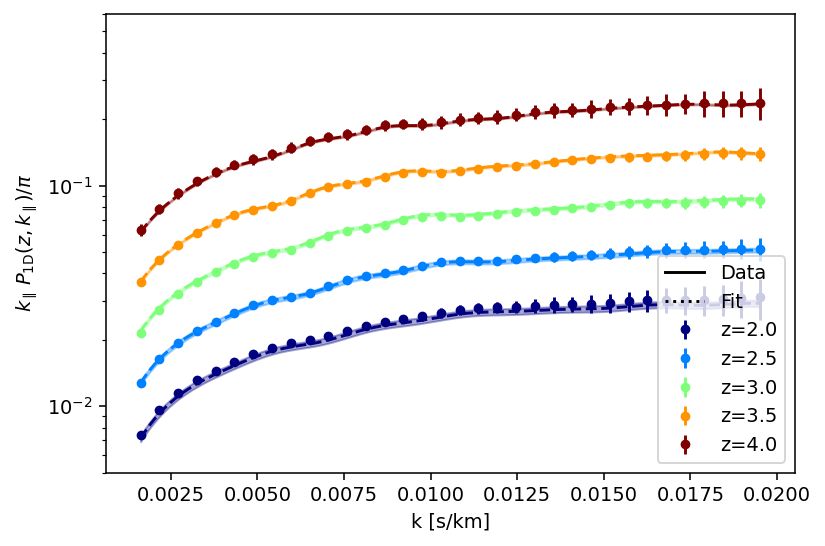

In [25]:
like.plot_p1d(plot_every_iz=2,values=m.values)

# Other cool things we can do with iminuit

In [26]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.360   |   0.033   |            |            |         |         |       |
| 1 | x1   |   0.42    |   0.07    |            |            |         |         |       |
| 2 | x2   |   0.537   |   0.035   |            |            |         |         |       |
| 3 | x3   |   0.27    |   0.11    |            |            |         |         |       |
| 4 | x4   |    0.3    |    0.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [27]:
# get proper errors from likelihood scans
m.minos()

-------------------------------------------------
|       x0        |            Valid            |
-------------------------------------------------
|      Error      |   -3.4e-2    |    3.4e-2    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x1        |            Valid            |
-------------------------------------------------
|      Error      |    -7e-2     |     7e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x2        |            Valid            |
-------------------------------------------------
|      Error      |    -4e-2     |     4e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x3        |            Valid            |
-------------------------------------------------
|      Error      |    -8e-2     |    56e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x4        |            Valid            |
-------------------------------------------------
|      Error      |    -0.11     |     0.19     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [28]:
# get best-fit values
m.np_values()

array([0.36023275, 0.42032514, 0.53730163, 0.27083296, 0.29500377])

In [29]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0']

In [30]:
# get parameters covariance
m.np_covariance()

array([[ 0.00110891,  0.00075887, -0.00096843, -0.00051749, -0.00148718],
       [ 0.00075887,  0.00465552, -0.00135973, -0.00162915,  0.00073303],
       [-0.00096843, -0.00135973,  0.00119461,  0.0004152 ,  0.00178594],
       [-0.00051749, -0.00162915,  0.0004152 ,  0.01282961,  0.00119463],
       [-0.00148718,  0.00073303,  0.00178594,  0.00119463,  0.01080077]])

(array([0.28386243, 0.31418747, 0.34451252, 0.37483757, 0.40516261,
        0.43548766, 0.46581271, 0.49613775, 0.5264628 , 0.55678784]),
 array([-13.54017124, -13.56927902, -14.17399491, -14.53836333,
        -14.72422946, -14.72286299, -14.52573069, -14.15636455,
        -13.66766575, -13.12670617]))

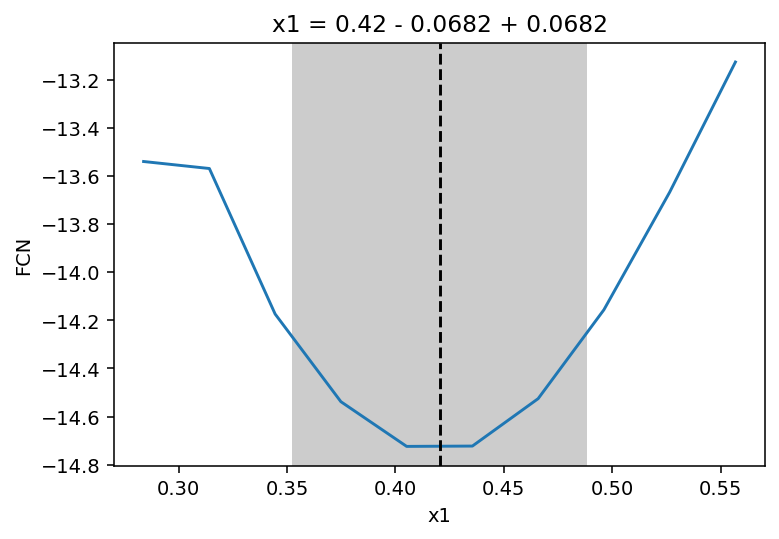

In [31]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

(array([0.04429719, 0.09463847, 0.14497975, 0.19532104, 0.24566232,
        0.2960036 , 0.34634488, 0.39668616, 0.44702744, 0.49736873]),
 array([-10.54921677, -12.28209232, -13.55053385, -14.36040817,
        -14.71632086, -14.73127421, -14.71396378, -14.76404868,
        -14.82116143, -14.85654642]))

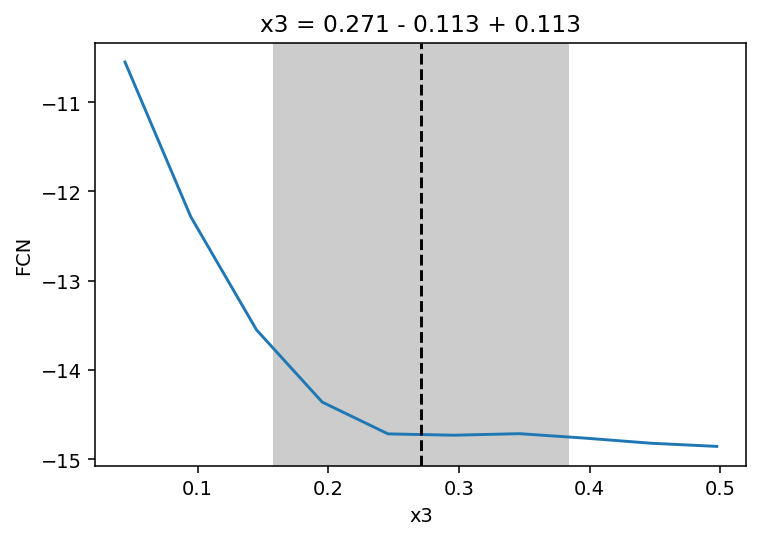

In [32]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

(array([0.2936322 , 0.30064278, 0.30765337, 0.31466395, 0.32167453,
        0.32868512, 0.3356957 , 0.34270629, 0.34971687, 0.35672746,
        0.36373804, 0.37074863, 0.37775921, 0.3847698 , 0.39178038,
        0.39879097, 0.40580155, 0.41281214, 0.41982272, 0.42683331]),
 array([0.28386243, 0.29822692, 0.31259142, 0.32695591, 0.34132041,
        0.35568491, 0.3700494 , 0.3844139 , 0.39877839, 0.41314289,
        0.42750738, 0.44187188, 0.45623637, 0.47060087, 0.48496537,
        0.49932986, 0.51369436, 0.52805885, 0.54242335, 0.55678784]),
 array([[1.47922769e+01, 1.36498060e+01, 1.25107195e+01, 1.14253480e+01,
         1.04305384e+01, 9.54815070e+00, 8.78796979e+00, 8.15159505e+00,
         7.63571594e+00, 7.23438453e+00, 6.94041345e+00, 6.74616185e+00,
         6.64395273e+00, 6.62630356e+00, 6.68609192e+00, 6.81673178e+00,
         7.01240484e+00, 7.26837361e+00, 7.58138704e+00, 7.95015965e+00],
        [1.35035290e+01, 1.23192315e+01, 1.11570664e+01, 1.00632330e+01,
         9.07

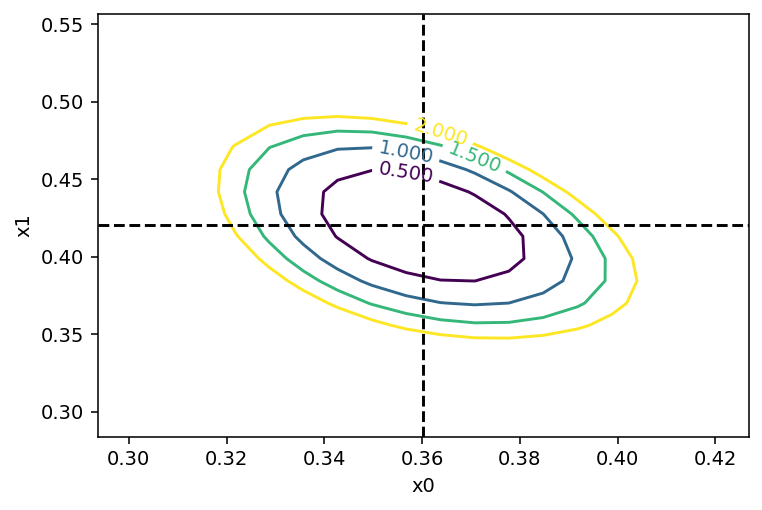

In [33]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [34]:
# matrix correlations
m.matrix(correlation=True)

-------------------------------------------
|    |     x0     x1     x2     x3     x4 |
-------------------------------------------
| x0 |  1.000  0.334 -0.841 -0.137 -0.430 |
| x1 |  0.334  1.000 -0.577 -0.211  0.103 |
| x2 | -0.841 -0.577  1.000  0.106  0.497 |
| x3 | -0.137 -0.211  0.106  1.000  0.101 |
| x4 | -0.430  0.103  0.497  0.101  1.000 |
-------------------------------------------

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


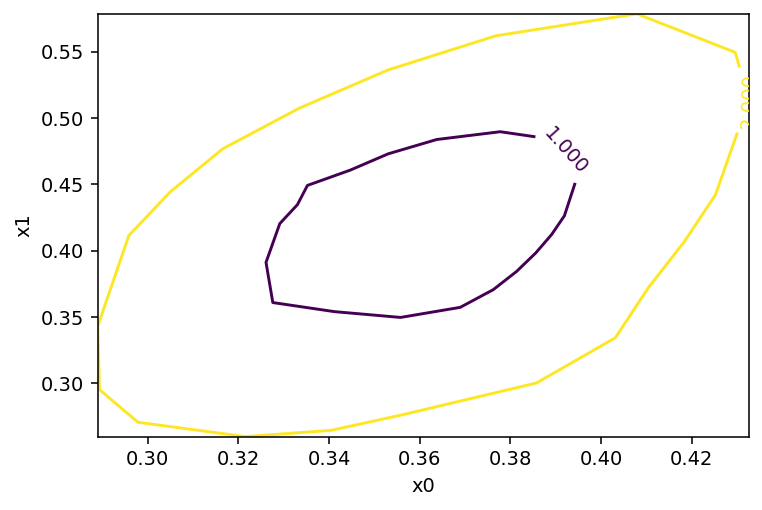

In [35]:
m.draw_mncontour('x0','x1',numpoints=20)